# Dance recognition challenge

## Setup
First we download the dataset and install missing packages.

In [ ]:
import zipfile
from pathlib import Path

# - Download of dataset
dataset_path = Path("/content") / "body-postures-dataset"

if not dataset_path.exists():
  !wget -q --show-progress https://www.dropbox.com/s/b9gfafnh6aesrsu/body-postures-dataset.bin
  # alternative mirror: https://lenzgregor.com/nextcloud/s/tbamCq9Eo95qfLc/download/body-postures-dataset.bin
  !mv body-postures-dataset.bin body-postures-dataset.tar.gz
  !tar -xzf body-postures-dataset.tar.gz

# - Install dataset as package
!pip install ./body-postures-dataset --quiet

# - Install torchmetrics
!pip install torchmetrics --quiet

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
import torch
import torchmetrics
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

from body_postures import BodyPostureFrames

## Data inspection

The original data consits of a continuous stream of asynchronous events - each with its own time stamp. On an asynchronous neuromorhpic processor, the dynamics of the network are continuous in time and are directly linked to the timings of the input events.

However, we are going to train our model on a CPU or GPU, which are synchronous (clocked) compute architectures. We therefore need to represent the envents in discretized time. We are going to use two different ways of arranging the events, depending on the type of neural network into which we are feeding the data.

### Frame representation

For artificial neural networks (ANNs), we will split the data stream of each recording into segments, each with the same, pre-defined number of events. 

In the individual segments we count the number of events for each pixel and channel. This way we eliminate the time dimension, such that each segment now has become a static frame. The frames could be compared to grey-scale images, with the brightness corresponding to the event count. Nothe that different to the frames of a conventional video camera, each frame here generally represents a different amount of time.

The frame based representation is provided by `BodyPostureFrames`, which is a subclass of a PyTorch dataset.

In [ ]:
?BodyPostureFrames

We will use this class to provide the input for training an ANN. Let's generate a training and and a test set. It might take a few seconds to convert the events into frames.

In [ ]:
# The number of events per frame
event_count = 3000

# Ignore pixels where the firing frequency exceeds a given value
hot_pixel_filter_freq = 60

# Training dataset
frame_dataset_training = BodyPostureFrames(
    data_path=dataset_path / "data" / "train",
    event_count=event_count,
    hot_pixel_filter_freq=hot_pixel_filter_freq,
    metadata_path=f'metadata/frames/train/{event_count}events_{hot_pixel_filter_freq}filter',
)

# Validation dataset
frame_dataset_validation = BodyPostureFrames(
    data_path=dataset_path / "data" / "test",
    event_count=event_count,
    hot_pixel_filter_freq=hot_pixel_filter_freq,
    metadata_path=f'metadata/frames/test/{event_count}events_{hot_pixel_filter_freq}filter',
)

classes = frame_dataset_training.classes
shape = frame_dataset_training.shape
n_classes = len(classes)


Read metadata from disk.
Read metadata from disk.


It can happen that some pixels of our sensor just produce random events at a high rate. We want to ignore these. With the `hot_pixel_filter_freq` argument we set an upper limit for which event rate we consider reasonable. Any pixel emitting events at a higher rate is probably just generating noise and will be ignored. 

For efficient data loading we do the conversion of events into frames only once and then buffer the data on disk, under the `metadata_path`.

Let's have a closer look at our data! For this we pick some frame from our training set:

Frame data type: <class 'numpy.ndarray'>
Frame shape: (1, 128, 128)
Frame sum: 3000.0
Max. number events at single pixel: 31.0


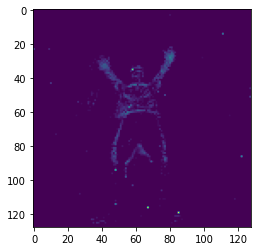

In [ ]:
sample_index = 42
frame, label = frame_dataset_training[sample_index]

print("Frame data type:", type(frame))
print("Frame shape:", frame.shape)
print("Frame sum:", frame.sum())
print("Max. number events at single pixel:", frame.max())
plt.imshow(frame[0])

The frame is a numpy array of shape (1, 128, 128). The first dimension is the number of channels, which in this case is 1. The other two dimensions correspond to the image size. We see that our input has a resolution of 128x128.

We also note that the total number of events in the frame is 3000, which is what we have previously defined with the `event_count` argument.

When plotting the frame, brighter areas correspond to regions with a higher number of events. Because events are generated from intensity changes, those are the regions where something is happening. Any static background becomes invisible and we only see the shape of the person moving in front of the sensor.

### Ground truth

Every sample in the dataset comes with a label that enumerates the correct class. The `classes` dict maps the names of the classes to their integer labels. There are five poses ("clap", "mj", "salive", "star" and "wave") as well as a "background" class for recordings without any person and "other", when a person is not performing any known move.

In [ ]:
print("Label:", label)
print(classes)

Label: 4
{'background': 0, 'clap': 1, 'mj': 2, 'salive': 3, 'star': 4, 'wave': 5, 'other': 6}


### BONUS TASK: Data balancing

The dataset is imbalanced. Let's look at training and testing set distribution and rectify the training set by using weighted random sampling.

You can skip this for now and come back to this task later.

In [ ]:
batch_size = 256
train_loader = DataLoader(
    dataset=frame_dataset_training, 
    batch_size=batch_size,
    # sampler= ...
    )

test_loader = DataLoader(
    dataset=frame_dataset_validation,
    batch_size=batch_size,
    )

In [ ]:
def plot_sample_dist(dataloader):
  resampled_targets = []
  for data, target in iter(dataloader):
    resampled_targets.append(target)
  resampled_targets = torch.cat(resampled_targets).numpy()

  plt.bar(classes.keys(), np.bincount(resampled_targets))
  plt.ylabel("Number of samples")

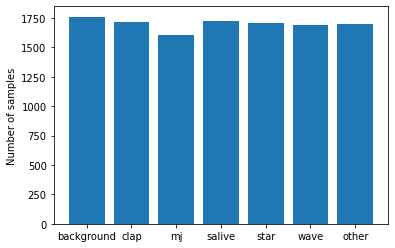

In [ ]:
# plot_sample_dist(train_loader)

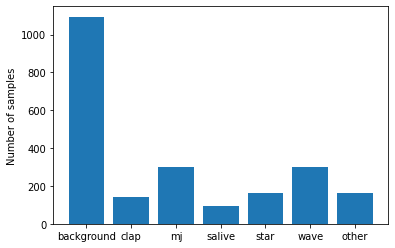

In [ ]:
plot_sample_dist(test_loader)

### Settings and hyperparameters

You can try out different learning rates and weight decays here, but the providedd defaults should yield reasonable results.

In [ ]:
learning_rate = 1e-3
weight_decay = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}.")

Using device cuda.


### Model definition

We suggest to use the following model architecture. Remember, the input shape of each frame is (1, 128, 128).

In [ ]:
class ANN(nn.Sequential):
    def __init__(self, n_classes=10):
        super().__init__(
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=2, padding=1, bias=False),  # 16, 64, 64
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 16, 32, 32
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=1, bias=False),  # 32, 16, 16
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 32, 8, 8
            nn.Dropout2d(0.25),
            
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1, bias=False),  # 64, 4, 4
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 64, 2, 2
            nn.Flatten(),
            nn.Dropout2d(0.5),
            
            nn.Linear(32*4*4, n_classes, bias=False),
        )

## Training

The stage is yours! Use the provided data loaders and model architecture to train an ANN that is able to classify the dance poses.

In [ ]:
### --- Train ANN here

# Convert ANN to SNN

In [ ]:
ann

ANN(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): Dropout2d(p=0.1, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (5): ReLU()
  (6): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (7): Dropout2d(p=0.25, inplace=False)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (9): ReLU()
  (10): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Dropout2d(p=0.5, inplace=False)
  (13): Linear(in_features=512, out_features=7, bias=False)
)

In [ ]:
sinabs_path = Path("/content") / "sinabs"

if not sinabs_path.exists():
  !git clone https://github.com/synsense/sinabs.git
  !cd sinabs; pip install . --quiet

Cloning into 'sinabs'...
remote: Enumerating objects: 3628, done.
remote: Counting objects: 100% (3628/3628), done.
remote: Compressing objects: 100% (1089/1089), done.
remote: Total 3628 (delta 2612), reused 3451 (delta 2483), pack-reused 0
Receiving objects: 100% (3628/3628), 2.71 MiB | 12.26 MiB/s, done.
Resolving deltas: 100% (2612/2612), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
import sinabs
import copy

ann_copy = copy.deepcopy(ann)

spike_layers = [name for name, child in ann_copy.cpu().named_children() if isinstance(child, nn.ReLU)]
param_layers = [name for name, child in ann_copy.cpu().named_children() if isinstance(child, (nn.Conv2d, nn.Linear))]
data = next(iter(train_loader))[0]

sinabs.utils.normalize_weights(ann_copy, data, output_layers=spike_layers, param_layers=param_layers)

We can scale the weights of the first layer to help the network with decision making. 

In [ ]:
with torch.no_grad():
  ann_copy[0].weight *= 5

In [ ]:
snn = sinabs.from_torch.from_model(ann_copy, input_shape=(1, 128, 128), add_spiking_output=True)
snn

Network(
  (spiking_model): ANN(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): IAFSqueeze
    (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): IAFSqueeze
    (6): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): IAFSqueeze
    (10): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Dropout2d(p=0.5, inplace=False)
    (13): Linear(in_features=512, out_features=7, bias=False)
    (Spiking output): IAFSqueeze
  )
  (analog_model): ANN(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), paddi

In [ ]:
torch.save(snn, 'model.pth')

## Evaluate converted SNN on raster data

### Event Representation

For spiking neural networks (SNNs) we use a similar representation to the frames we used for the ANN. However, here we want to maintain a notion of time, to mimick the neuron dynamics on the neuromorphic processor. We therefore arrange our events in time along a grid of very short intervals, corresponding to a simulation time step. This time step should be chosen small enough such that the neuron dynamics are well approximated. On the other hand, choosing it too short will slow down our simulations. We will come back to this later, when we do inference on a SNN.

In [ ]:
from body_postures import BodyPostureEvents

In [ ]:
try:
  snn = torch.load('model.pth')
  print("Loaded saved model.")
except Exception as e:
  print(e)

Loaded saved model.


In [ ]:
?BodyPostureEvents

In [ ]:
slice_dt = 2e6 # microseconds
bin_dt = 2e3
batch_size = 1

raster_test_dataset = BodyPostureEvents(
    data_path=dataset_path / "data" / "test",
    cache_path=f"cache/test/{slice_dt}/{bin_dt}",
    slice_dt=slice_dt,
    bin_dt=bin_dt,
    metadata_path=f"metadata/raster/test/{slice_dt}/{bin_dt}",
    hot_pixel_filter_freq=hot_pixel_filter_freq,
)

test_loader = DataLoader(raster_test_dataset, shuffle=True, batch_size=batch_size)

Metadata written to disk.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

snn.eval()
snn = snn.to(device)

val_data = []
batch_loss = []
for data, labels in tqdm(test_loader):
  with torch.no_grad():
    snn.reset_states()
    data = data.to(device)
    data = data.flatten(0, 1).float()
    spikes = snn(data).unflatten(0, (batch_size, -1))

    # Collect outputs and labels
    labels = labels.to(device)
    predictions = spikes.sum(1).argmax(dim=1) 
    val_data.append(predictions.eq(labels.view_as(predictions)))
    print(f"Spike output: {spikes.sum(1).int().tolist()[0]}, label was {labels.item()}. Overall accuracy: {round((sum(val_data)/len(val_data)).item(), 3)}")  

  0%|          | 0/263 [00:00<?, ?it/s]

Spike output: [0, 4, 1, 4, 0, 0, 0], label was 3. Overall accuracy: 0.0
Spike output: [0, 3, 0, 4, 3, 0, 0], label was 3. Overall accuracy: 0.5
Spike output: [0, 3, 1, 5, 2, 0, 0], label was 3. Overall accuracy: 0.667
Spike output: [0, 4, 1, 1, 2, 0, 0], label was 4. Overall accuracy: 0.5
Spike output: [0, 15, 0, 0, 0, 36, 0], label was 5. Overall accuracy: 0.6
Spike output: [0, 0, 16, 3, 3, 0, 0], label was 2. Overall accuracy: 0.667
Spike output: [0, 13, 0, 0, 0, 28, 0], label was 5. Overall accuracy: 0.714
Spike output: [0, 0, 0, 0, 0, 26, 0], label was 5. Overall accuracy: 0.75
Spike output: [0, 6, 5, 4, 6, 0, 0], label was 4. Overall accuracy: 0.667
Spike output: [0, 0, 0, 0, 0, 31, 0], label was 5. Overall accuracy: 0.7
Spike output: [0, 2, 1, 6, 1, 0, 0], label was 3. Overall accuracy: 0.727
Spike output: [0, 9, 7, 7, 7, 0, 0], label was 4. Overall accuracy: 0.667
Spike output: [0, 11, 0, 0, 0, 26, 0], label was 5. Overall accuracy: 0.692
Spike output: [0, 4, 1, 3, 2, 0, 0], lab

KeyboardInterrupt: ignored